In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn_extra.cluster import KMedoids
from tslearn.metrics import cdist_dtw

from dotenv import load_dotenv

load_dotenv()
BASE_DATA_PATH = os.environ.get('BASE_DATA_PATH')

### Same pipeline as at stage 5

In [3]:
df_all_stations_filtered = pd.read_csv(os.path.join(BASE_DATA_PATH, r'v2_df_all_stations_filtered.csv'), parse_dates=['date'])
df_all_stations_filtered

,date,station_id,rain,relative_hum,mean_temp,wind
0,2024-01-30 00:00:00+00:00,2592,2.8,90.52,16.50,10.93
1,2024-01-29 00:00:00+00:00,2592,1.0,90.47,16.50,13.76
2,2024-01-28 00:00:00+00:00,2592,2.8,79.11,17.10,7.13
3,2024-01-27 00:00:00+00:00,2592,0.0,58.74,20.30,15.34
4,2024-01-26 00:00:00+00:00,2592,0.6,62.95,17.70,9.49
...,...,...,...,...,...,...
17451,2017-04-30 00:00:00+00:00,41559,9.8,70.00,11.88,7.49
17452,2017-04-29 00:00:00+00:00,41559,20.2,92.75,16.08,2.55
17453,2017-04-28 00:00:00+00:00,41559,1.4,90.43,16.45,3.19
17454,2017-04-27 00:00:00+00:00,41559,0.0,82.42,16.92,4.06


In [4]:
def get_time_period(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    flt = (df['date'] >= start_date) & (df['date'] <= end_date)
    return df.loc[flt].sort_values(['station_id', 'date'], ascending=[True, False]).reset_index(drop=True)

In [5]:
start_date = '2019-07-01'
# start_date = '2021-02-01'
end_date = '2023-01-31'
df_all_stations_period = get_time_period(df_all_stations_filtered, start_date=start_date, end_date=end_date)
print(df_all_stations_period.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15024 entries, 0 to 15023
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   date          15024 non-null  datetime64[ns, UTC]
 1   station_id    15024 non-null  int64              
 2   rain          15024 non-null  float64            
 3   relative_hum  15024 non-null  float64            
 4   mean_temp     15024 non-null  float64            
 5   wind          15024 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 704.4 KB
None


In [ ]:
# first 0 values replaced by NaN
df_all_stations_period['relative_hum'] = df_all_stations_period['relative_hum'].replace({0.0:np.nan})
df_all_stations_period.set_index('date', inplace=True)
print(f"Number incorrect rows: {len(df_all_stations_period[df_all_stations_period['relative_hum'].isna()])}")
display(df_all_stations_period[df_all_stations_period['relative_hum'].isna()].head())

df_all_stations_period['relative_hum'] = df_all_stations_period[['relative_hum']].interpolate(method='time').round(2)
df_all_stations_period.reset_index(inplace=True)
# display(df_all_stations_period.iloc[12426:12507].head(40)[:40])
display(df_all_stations_period)

Number incorrect rows: 31


,station_id,rain,relative_hum,mean_temp,wind
date,,,,,
2022-04-12 00:00:00+00:00,41212,16.0,NaN,16.3,8.25
2022-04-11 00:00:00+00:00,41212,2.0,NaN,17.4,9.21
2022-04-10 00:00:00+00:00,41212,0.0,NaN,17.1,6.00
2022-04-09 00:00:00+00:00,41212,0.0,NaN,14.0,4.65
2022-04-08 00:00:00+00:00,41212,0.0,NaN,16.5,4.92


,date,station_id,rain,relative_hum,mean_temp,wind
0,2023-01-26 00:00:00+00:00,2592,0.0,83.82,18.00,7.01
1,2023-01-25 00:00:00+00:00,2592,0.0,77.95,17.40,7.29
2,2023-01-24 00:00:00+00:00,2592,0.0,73.75,17.50,3.72
3,2023-01-23 00:00:00+00:00,2592,0.0,74.16,16.40,4.03
4,2023-01-22 00:00:00+00:00,2592,0.0,68.07,19.00,7.81
...,...,...,...,...,...,...
15019,2019-07-05 00:00:00+00:00,41559,1.4,70.88,9.17,6.40
15020,2019-07-04 00:00:00+00:00,41559,9.4,77.50,9.74,6.78
15021,2019-07-03 00:00:00+00:00,41559,30.8,93.42,14.38,3.66
15022,2019-07-02 00:00:00+00:00,41559,1.8,71.42,14.13,2.85


### Aggregate df_all_stations_period by 3 months (season) intervals. rain -sum, other columns - mean

In [ ]:
df_all_stations_season = df_all_stations_period.groupby(['station_id', pd.Grouper(key='date', freq='3M')]).mean().reset_index()
df_all_stations_season_rain = df_all_stations_period.groupby(['station_id', pd.Grouper(key='date', freq='3M')])['rain'].sum().reset_index()
df_all_stations_season['rain'] = df_all_stations_season_rain['rain']
display(df_all_stations_season)

C:\Users\LenAlex\AppData\Local\Temp\ipykernel_30148\1570256692.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_all_stations_season = df_all_stations_period.groupby(['station_id', pd.Grouper(key='date', freq='3M')]).mean().reset_index()
C:\Users\LenAlex\AppData\Local\Temp\ipykernel_30148\1570256692.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_all_stations_season_rain = df_all_stations_period.groupby(['station_id', pd.Grouper(key='date', freq='3M')])['rain'].sum().reset_index()


,station_id,date,rain,relative_hum,mean_temp,wind
0,2592,2019-07-31 00:00:00+00:00,52.4,81.065714,11.235714,8.214643
1,2592,2019-10-31 00:00:00+00:00,148.4,75.705349,11.326744,9.314070
2,2592,2020-01-31 00:00:00+00:00,61.2,70.687403,17.305195,9.181169
3,2592,2020-04-30 00:00:00+00:00,3.8,72.574000,18.440000,7.690800
4,2592,2020-07-31 00:00:00+00:00,98.0,83.891034,11.032759,7.068793
...,...,...,...,...,...,...
235,41559,2022-01-31 00:00:00+00:00,258.4,78.664750,17.159375,3.473250
236,41559,2022-04-30 00:00:00+00:00,261.2,77.511169,16.311948,3.309740
237,41559,2022-07-31 00:00:00+00:00,465.0,81.921410,11.872821,2.736923
238,41559,2022-10-31 00:00:00+00:00,281.0,79.791974,11.519079,3.453684


In [24]:
from sklearn.preprocessing import StandardScaler

columns_to_standardize = ['rain', 'relative_hum', 'mean_temp', 'wind']
df_all_stations_season_scaled = df_all_stations_season[['date', 'station_id', 'rain', 'relative_hum', 'mean_temp', 'wind']]
df_all_stations_season_scaled[columns_to_standardize] = StandardScaler().fit_transform(df_all_stations_season[columns_to_standardize])
df_all_stations_season_scaled

,date,station_id,rain,relative_hum,mean_temp,wind
0,2019-07-31 00:00:00+00:00,2592,-1.120235,0.843563,-0.845790,1.483944
1,2019-10-31 00:00:00+00:00,2592,-0.209747,-0.324014,-0.813805,1.988983
2,2020-01-31 00:00:00+00:00,2592,-1.036774,-1.417006,1.286825,1.927933
3,2020-04-30 00:00:00+00:00,2592,-1.581170,-1.006074,1.685558,1.243308
4,2020-07-31 00:00:00+00:00,2592,-0.687753,1.458965,-0.917102,0.957579
...,...,...,...,...,...,...
235,2022-01-31 00:00:00+00:00,41559,0.833521,0.320593,1.235589,-0.694092
236,2022-04-30 00:00:00+00:00,41559,0.860077,0.069324,0.937831,-0.769203
237,2022-07-31 00:00:00+00:00,41559,2.792967,1.029948,-0.621932,-1.032336
238,2022-10-31 00:00:00+00:00,41559,1.047865,0.566121,-0.746225,-0.703080


In [25]:
def plot_all_parameters(df, stations_to_plot=None, rows_number=None):
    
    if stations_to_plot:
        stations_to_plot = stations_to_plot
    else:
        stations_to_plot = df['station_id'].unique()

    y_feature = {
            'rain': 'mm',
            'relative_hum': '%',
            'mean_temp': '⁰C',
            'wind': 'm/s'
        }

    features = ['rain', 'relative_hum', 'mean_temp', 'wind']

    fig, axes = plt.subplots(1, 4, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        for station in stations_to_plot:
            station_data = df[df['station_id'] == station].iloc[:rows_number]
            axes[i].plot(station_data['date'], station_data[feature], label=f'Station {station}')
            axes[i].set_xlabel('Date')
            axes[i].tick_params(axis='x', rotation=45)
        
        axes[i].set_ylabel(y_feature[feature])
        axes[i].set_title(f'{feature.capitalize()} Over Time')
        axes[i].grid(True)


    axes[0].legend(title='Station ID', bbox_to_anchor=(0.4, 1))
    plt.suptitle(f'Weather Parameters Over Time {rows_number} Days', fontsize=16)

    plt.show()

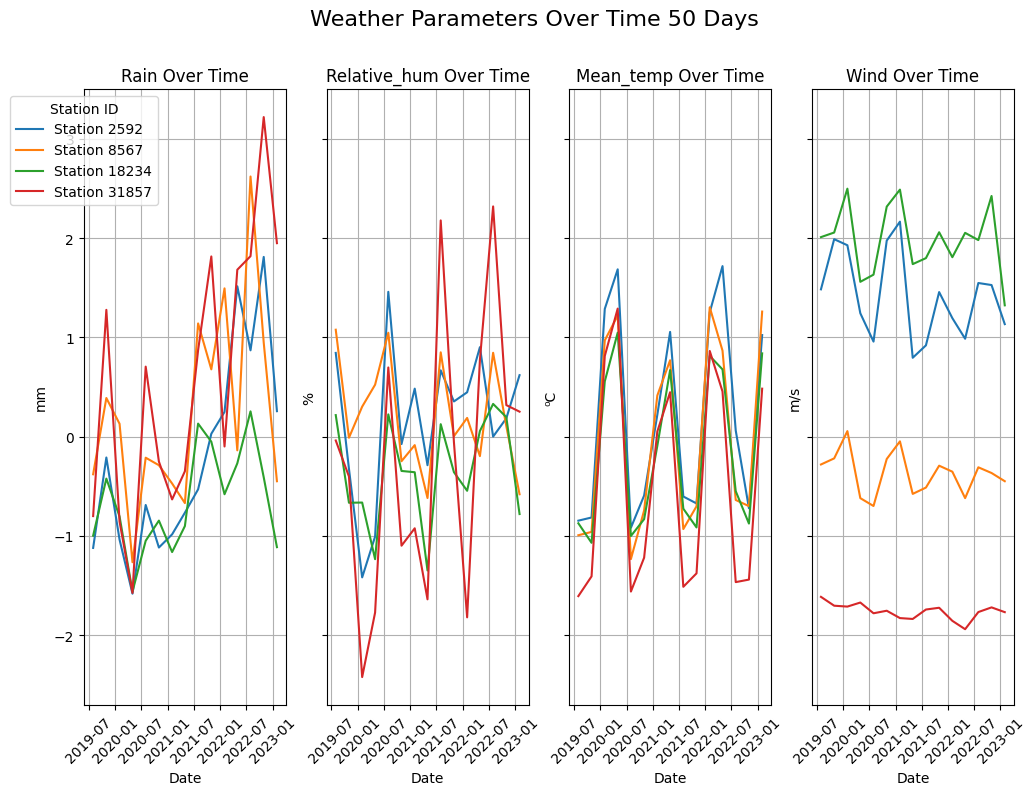

In [26]:
stations_to_plot = [2592, 8567, 18234, 31857]
rows_number = 50
plot_all_parameters(df_all_stations_season_scaled, stations_to_plot, rows_number)

In [27]:
df_pivot = df_all_stations_season_scaled[['date', 'station_id', 'rain', 'relative_hum', 'mean_temp', 'wind']].pivot(index='station_id', columns='date')
# print(df_pivot.columns)
df_pivot.to_csv(os.path.join(BASE_DATA_PATH, r'v2_df_pivot_seasons.csv'))
display(df_pivot)

rain                            \
date       2019-07-31 00:00:00+00:00 2019-10-31 00:00:00+00:00   
station_id                                                       
2592                       -1.120235                 -0.209747   
2685                       -0.936241                 -0.953312   
3145                       -0.103523                  0.649526   
3445                       -0.409865                  0.705483   
8567                       -0.378567                  0.389658   
12442                      -0.202160                  0.499675   
18234                      -0.996940                 -0.422194   
21938                      -0.907788                  0.063399   
25354                      -0.154738                  1.028896   
25531                      -0.573942                 -0.076967   
31857                      -0.799668                  1.277384   
40750                      -0.253375                  1.171160   
40984                      -1.142998                 -0.031443   
41212                      -0.333042                  0.609692   
41229                      -1.309162                 -1.040378   
41559                      -0.228716                  0.421904   

                                                                \
date       2020-01-31 00:00:00+00:00 2020-04-30 00:00:00+00:00   
station_id                                                       
2592                       -1.036774                 -1.581170   
2685                       -0.858470                 -1.594448   
3145                        0.512953                 -1.193264   
3445                       -0.222077                 -1.492018   
8567                        0.129789                 -1.264396   
12442                       0.313784                 -1.253015   
18234                      -0.803461                 -1.560305   
21938                      -0.875542                 -1.577376   
25354                       0.120305                 -1.383898   
25531                       0.232219                 -1.389588   
31857                      -0.855625                 -1.573583   
40750                       0.459841                 -1.235943   
40984                      -1.032980                 -1.577376   
41212                      -0.241993                 -1.526161   
41229                      -1.256145                 -1.584015   
41559                       0.552787                 -1.340270   

                                                                \
date       2020-07-31 00:00:00+00:00 2020-10-31 00:00:00+00:00   
station_id                                                       
2592                       -0.687753                 -1.116442   
2685                       -0.685857                 -0.720000   
3145                        0.017875                 -0.042824   
3445                       -0.428833                 -0.370979   
8567                       -0.211644                 -0.287518   
12442                      -0.219231                 -0.158532   
18234                      -1.048155                 -0.845192   
21938                      -0.572045                 -0.827172   
25354                      -0.021959                  0.175314   
25531                      -0.646023                 -0.496171   
31857                       0.705483                 -0.250529   
40750                      -0.059896                 -0.018165   
40984                      -0.678269                 -0.537902   
41212                      -0.291312                 -0.369082   
41229                      -1.361610                 -1.304325   
41559                      -0.395638                 -0.498068   

                                                                \
date       2021-01-31 00:00:00+00:00 2021-04-30 00:00:00+00:00   
station_id                                                       
2592                       -0.983662                 -0.765524   
268

In [28]:
def elbow_plot_and_silhuette(data, k):
    list_n_clusters = []
    inertias = []

    for n_clusters in range(1, k):
        kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=14)
        kmeans.fit(data)
        list_n_clusters.append(n_clusters)
        inertias.append(kmeans.inertia_)
        if n_clusters > 1:
            print(f'n_clusters: {n_clusters}, silhuette score: {silhouette_score(data, kmeans.labels_).round(5)}')
  
    plt.plot(list_n_clusters, inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot')
    plt.grid(True)
    plt.show()

n_clusters: 2, silhuette score: 0.32428
n_clusters: 3, silhuette score: 0.23668
n_clusters: 4, silhuette score: 0.25154
n_clusters: 5, silhuette score: 0.23149
n_clusters: 6, silhuette score: 0.20793
n_clusters: 7, silhuette score: 0.19996
n_clusters: 8, silhuette score: 0.20614


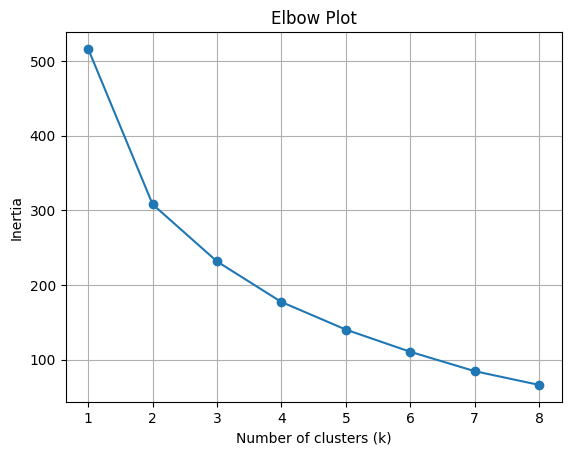

In [31]:
elbow_plot_and_silhuette(df_pivot, 9)

In [32]:
n_clusters = 2
X = df_pivot

In [33]:
kmeans_model = KMeans(n_clusters=n_clusters, n_init=20 ,random_state=14)
kmeans_model.fit_predict(X)
kmeans_labels = kmeans_model.labels_
print(kmeans_labels)

[1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0]


In [ ]:
kmedoids_model = KMedoids(n_clusters=n_clusters, random_state=14, metric='euclidean')#  metric="precomputed")
kmedoids_model.fit(X)
kmedoids_labels = kmedoids_model.labels_
print(kmedoids_labels)
# print(X.index)

[0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1]
Index([ 2592,  2685,  3145,  3445,  8567, 12442, 18234, 21938, 25354, 25531,
       31857, 40750, 40984, 41212, 41229, 41559],
      dtype='int64', name='station_id')


In [35]:
dtw_distance_matrix = cdist_dtw(X.values)

In [36]:
kmedoids_model_dtw = KMedoids(n_clusters=n_clusters, random_state=14, metric='euclidean')#  metric="precomputed")
kmedoids_model_dtw.fit(dtw_distance_matrix)
kmedoids_labels_dtw = kmedoids_model_dtw.labels_
print(kmedoids_labels_dtw)
print(X.index)

[0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1]
Index([ 2592,  2685,  3145,  3445,  8567, 12442, 18234, 21938, 25354, 25531,
       31857, 40750, 40984, 41212, 41229, 41559],
      dtype='int64', name='station_id')


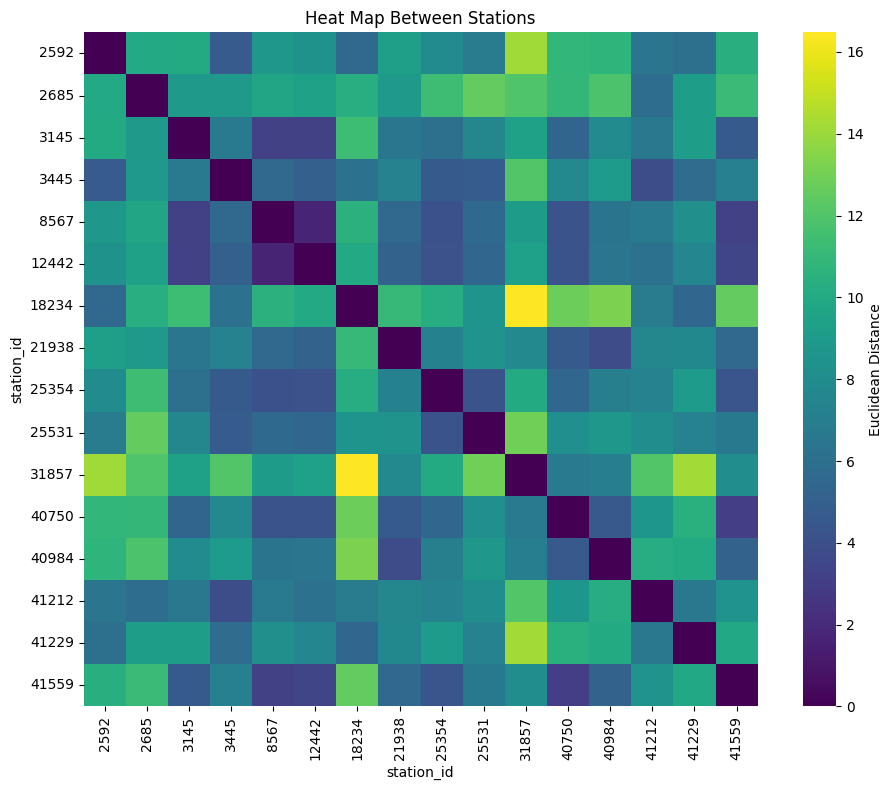

In [37]:
full_distance_matrix = squareform(pdist(X))
station_ids = [X.index]
distance_df = pd.DataFrame(full_distance_matrix, index=station_ids, columns=station_ids)
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, cmap='viridis', annot=False, square=True, cbar_kws={'label': 'Euclidean Distance'})
plt.title('Heat Map Between Stations')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

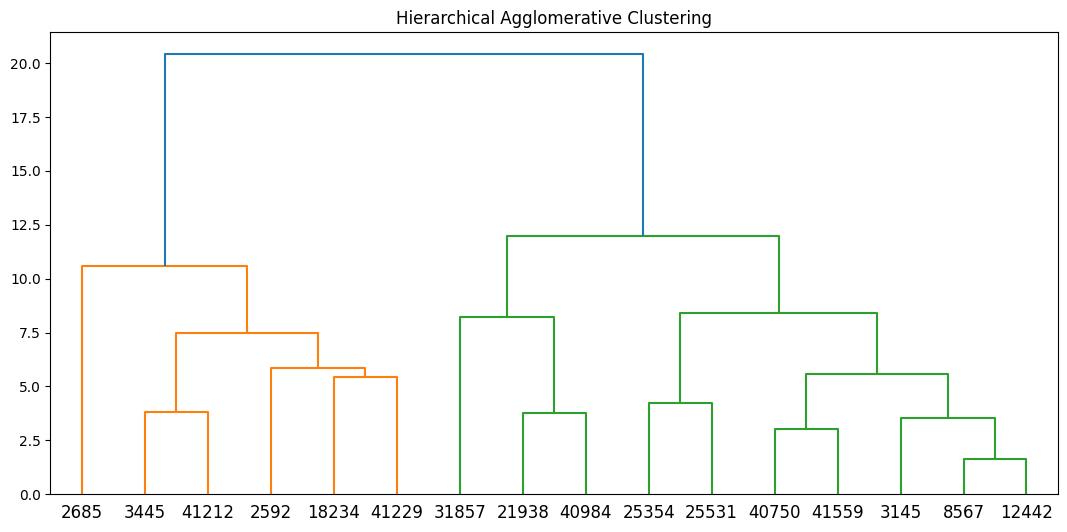

In [38]:
plt.figure(figsize=(13, 6))
Z = linkage(X, method='ward')
dendrogram(
        Z,
        orientation='top',
        labels=df_pivot.index,
        distance_sort='ascending',
        show_leaf_counts=False, 
)
plt.title('Hierarchical Agglomerative Clustering')
plt.show()

In [39]:
hierarchical_model = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical_model.fit(X)
hierarchical_labels = hierarchical_model.labels_
print(hierarchical_labels)

[1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0]


In [40]:
hierarchical_model_dwt = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical_model_dwt.fit(dtw_distance_matrix)
hierarchical_labels_dwt = hierarchical_model_dwt.labels_
print(hierarchical_labels_dwt)

[1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0]


c:\D\Whitireia\ARP\clustering-wellington-weather-stations\.venv\Lib\site-packages\scipy\cluster\hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [41]:
def print_scores(X, labels):
    """ Prints 3 Scores for given data and labels.
    X : A list of n_features-dimensional data points. Each row corresponds to a single data point., 
    labels : Predicted labels for each sample.
    """
    print("Silhouette Score:", (silhouette_score(X, labels)).round(5))
    print("Davies-Bouldin Index:", (davies_bouldin_score(X, labels)).round(5))
    print("Calinski-Harabasz Index:", (calinski_harabasz_score(X, labels)).round(5))

In [42]:
algorithm_results = {
    'KMeans': kmeans_labels, 
    'KMedoids': kmedoids_labels, 
    'KMedoids-DTW': kmedoids_labels_dtw,
    'AgglomerativeClustering': hierarchical_labels,
    'AgglomerativeClustering-DTW': hierarchical_labels_dwt,
}

for name in algorithm_results:
    print(f'\nScores for {name}:')
    print_scores(X, algorithm_results[name])


Scores for KMeans:
Silhouette Score: 0.32428
Davies-Bouldin Index: 1.11927
Calinski-Harabasz Index: 9.4668

Scores for KMedoids:
Silhouette Score: 0.31408
Davies-Bouldin Index: 1.14773
Calinski-Harabasz Index: 9.46005

Scores for KMedoids-DTW:
Silhouette Score: 0.31408
Davies-Bouldin Index: 1.14773
Calinski-Harabasz Index: 9.46005

Scores for AgglomerativeClustering:
Silhouette Score: 0.32428
Davies-Bouldin Index: 1.11927
Calinski-Harabasz Index: 9.4668

Scores for AgglomerativeClustering-DTW:
Silhouette Score: 0.27619
Davies-Bouldin Index: 1.14118
Calinski-Harabasz Index: 7.25747


In [45]:
stations_path = pathlib.Path('stations.csv').resolve()
stations_to_map = pd.read_csv(stations_path).sort_values(['StationID']).reset_index(drop=True)
for name in algorithm_results:
    stations_to_map[name] = algorithm_results[name]
    print(name)
    display(stations_to_map.sort_values([name, 'StationID'], axis=0))

KMeans


,StationID,StationName,latitude,longitude,KMeans
2,3145,PARAPARAUMU AERO,-40.90700,174.98400,0
4,8567,PARAPARAUMU AERO AWS,-40.90455,174.98517,0
5,12442,PARAPARAUMU AERO EWS,-40.90392,174.98437,0
7,21938,MARTINBOROUGH EWS,-41.25231,175.38985,0
8,25354,"WELLINGTON, KELBURN AWS",-41.28445,174.76794,0
9,25531,MANA ISLAND AWS,-41.08676,174.77996,0
10,31857,"TE WHARAU, BRACKENFIELD",-41.17278,175.80063,0
11,40750,"UPPER HUTT, TRENTHAM EWS",-41.14027,175.04283,0
12,40984,MASTERTON EWS,-40.98155,175.67932,0
15,41559,"PORIRUA, ELSDON PARK AWS",-41.12683,174.83531,0


KMedoids


,StationID,StationName,latitude,longitude,KMeans,KMedoids
0,2592,CASTLEPOINT AWS,-40.90416,176.21207,1,0
1,2685,NGAWI AWS,-41.58850,175.23370,1,0
3,3445,WELLINGTON AERO,-41.32200,174.80400,1,0
6,18234,BARING HEAD,-41.40828,174.87146,1,0
9,25531,MANA ISLAND AWS,-41.08676,174.77996,0,0
13,41212,"WELLINGTON, GRETA POINT CWS",-41.30243,174.80574,1,0
14,41229,WELLINGTON AERO BACKUP AWS,-41.33130,174.80566,1,0
2,3145,PARAPARAUMU AERO,-40.90700,174.98400,0,1
4,8567,PARAPARAUMU AERO AWS,-40.90455,174.98517,0,1
5,12442,PARAPARAUMU AERO EWS,-40.90392,174.98437,0,1


KMedoids-DTW


,StationID,StationName,latitude,longitude,KMeans,KMedoids,KMedoids-DTW
0,2592,CASTLEPOINT AWS,-40.90416,176.21207,1,0,0
1,2685,NGAWI AWS,-41.58850,175.23370,1,0,0
3,3445,WELLINGTON AERO,-41.32200,174.80400,1,0,0
6,18234,BARING HEAD,-41.40828,174.87146,1,0,0
9,25531,MANA ISLAND AWS,-41.08676,174.77996,0,0,0
13,41212,"WELLINGTON, GRETA POINT CWS",-41.30243,174.80574,1,0,0
14,41229,WELLINGTON AERO BACKUP AWS,-41.33130,174.80566,1,0,0
2,3145,PARAPARAUMU AERO,-40.90700,174.98400,0,1,1
4,8567,PARAPARAUMU AERO AWS,-40.90455,174.98517,0,1,1
5,12442,PARAPARAUMU AERO EWS,-40.90392,174.98437,0,1,1


AgglomerativeClustering


,StationID,StationName,latitude,longitude,KMeans,KMedoids,KMedoids-DTW,AgglomerativeClustering
2,3145,PARAPARAUMU AERO,-40.90700,174.98400,0,1,1,0
4,8567,PARAPARAUMU AERO AWS,-40.90455,174.98517,0,1,1,0
5,12442,PARAPARAUMU AERO EWS,-40.90392,174.98437,0,1,1,0
7,21938,MARTINBOROUGH EWS,-41.25231,175.38985,0,1,1,0
8,25354,"WELLINGTON, KELBURN AWS",-41.28445,174.76794,0,1,1,0
9,25531,MANA ISLAND AWS,-41.08676,174.77996,0,0,0,0
10,31857,"TE WHARAU, BRACKENFIELD",-41.17278,175.80063,0,1,1,0
11,40750,"UPPER HUTT, TRENTHAM EWS",-41.14027,175.04283,0,1,1,0
12,40984,MASTERTON EWS,-40.98155,175.67932,0,1,1,0
15,41559,"PORIRUA, ELSDON PARK AWS",-41.12683,174.83531,0,1,1,0


AgglomerativeClustering-DTW


,StationID,StationName,latitude,longitude,KMeans,KMedoids,KMedoids-DTW,AgglomerativeClustering,AgglomerativeClustering-DTW
1,2685,NGAWI AWS,-41.58850,175.23370,1,0,0,1,0
2,3145,PARAPARAUMU AERO,-40.90700,174.98400,0,1,1,0,0
4,8567,PARAPARAUMU AERO AWS,-40.90455,174.98517,0,1,1,0,0
5,12442,PARAPARAUMU AERO EWS,-40.90392,174.98437,0,1,1,0,0
7,21938,MARTINBOROUGH EWS,-41.25231,175.38985,0,1,1,0,0
8,25354,"WELLINGTON, KELBURN AWS",-41.28445,174.76794,0,1,1,0,0
9,25531,MANA ISLAND AWS,-41.08676,174.77996,0,0,0,0,0
10,31857,"TE WHARAU, BRACKENFIELD",-41.17278,175.80063,0,1,1,0,0
11,40750,"UPPER HUTT, TRENTHAM EWS",-41.14027,175.04283,0,1,1,0,0
12,40984,MASTERTON EWS,-40.98155,175.67932,0,1,1,0,0


,StationID,StationName,latitude,longitude,KMeans,KMedoids,KMedoids-DTW,AgglomerativeClustering,AgglomerativeClustering-DTW
2,3145,PARAPARAUMU AERO,-40.90700,174.98400,0,1,1,0,0
4,8567,PARAPARAUMU AERO AWS,-40.90455,174.98517,0,1,1,0,0
5,12442,PARAPARAUMU AERO EWS,-40.90392,174.98437,0,1,1,0,0
7,21938,MARTINBOROUGH EWS,-41.25231,175.38985,0,1,1,0,0
8,25354,"WELLINGTON, KELBURN AWS",-41.28445,174.76794,0,1,1,0,0
9,25531,MANA ISLAND AWS,-41.08676,174.77996,0,0,0,0,0
10,31857,"TE WHARAU, BRACKENFIELD",-41.17278,175.80063,0,1,1,0,0
11,40750,"UPPER HUTT, TRENTHAM EWS",-41.14027,175.04283,0,1,1,0,0
12,40984,MASTERTON EWS,-40.98155,175.67932,0,1,1,0,0
15,41559,"PORIRUA, ELSDON PARK AWS",-41.12683,174.83531,0,1,1,0,0


Cluster: 0, Colour: darkgreen
Cluster: 1, Colour: darkred


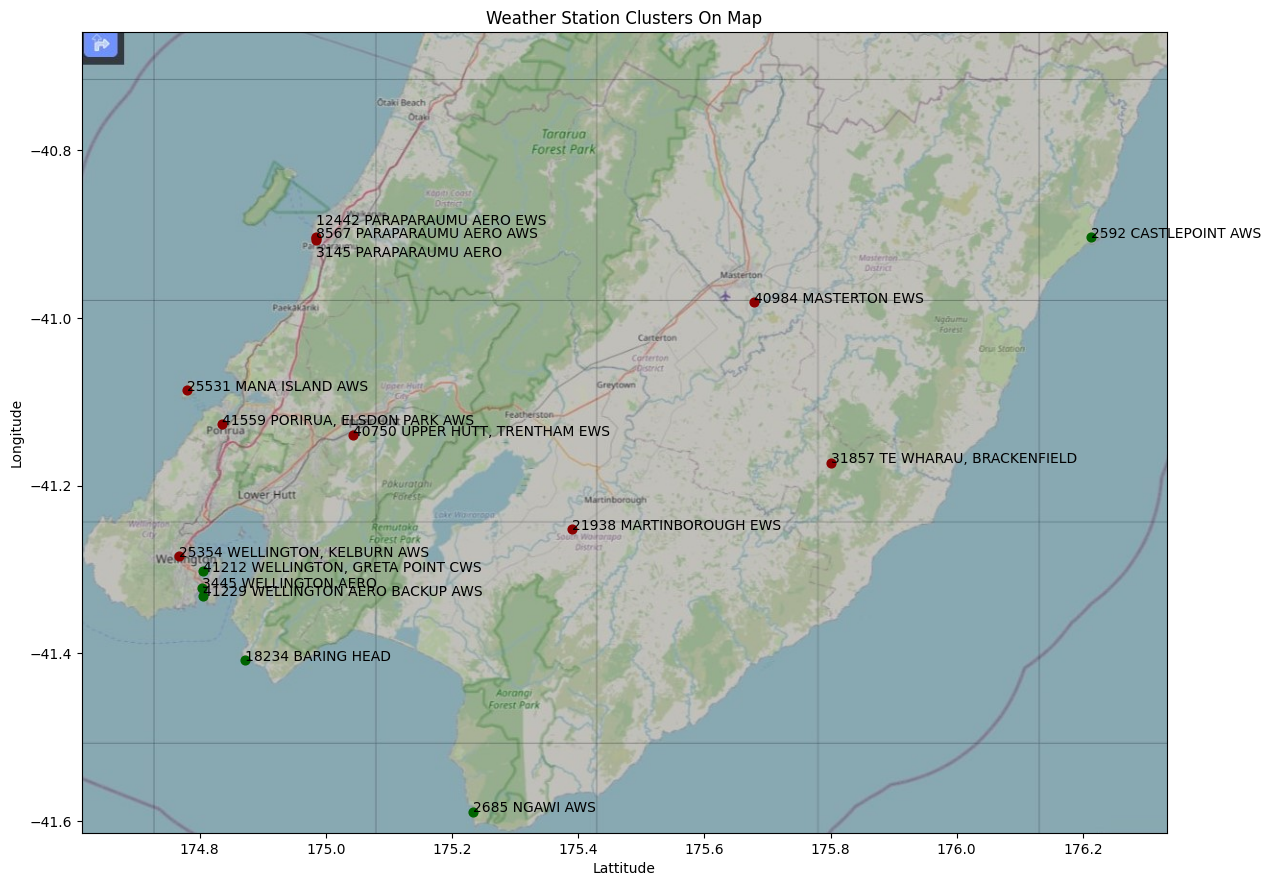

In [48]:
display(stations_to_map.sort_values(['KMeans', 'StationID'], axis=0))

bounds = (
        174.613136, 176.332929, # longitude - X
        -41.613738, -40.65948 # latitude - Y
)

n_clusters = stations_to_map['KMeans'].unique()

colours = {
    0: 'darkgreen', 
    1: 'darkred', 
    2: 'yellow',
    3: 'blue',
    4: 'purple',
    5: 'pink'
}

fig, ax = plt.subplots(figsize = (14,12))
ax.set_title('Weather Station Clusters On Map')
ax.set_xlabel('Lattitude')
ax.set_ylabel('Longitude')

for i in range(len(n_clusters)):
        df_temp = stations_to_map.loc[stations_to_map['KMeans'] == n_clusters[i]]
        ax.scatter(df_temp['longitude'], df_temp['latitude'], zorder=1, alpha=1, c=colours[i], s=40)
        print(f'Cluster: {i}, Colour: {colours[i]}')

x = stations_to_map['longitude']
y = stations_to_map['latitude']

station_name = stations_to_map['StationName'] + stations_to_map['StationID'].astype(str)
station_name = stations_to_map['StationID'].astype(str) + " " + stations_to_map['StationName']
# print(type(station_name), station_name)
for i, txt in enumerate(station_name):
    y_i = y[i]
    if txt == '3145 PARAPARAUMU AERO':
        y_i = y[i] - 0.02
    elif txt == '12442 PARAPARAUMU AERO EWS':
        y_i = y[i] + 0.015
    ax.annotate(txt, (x[i], y_i))

img_path = pathlib.Path('greater_wellington_map.jpg').resolve()
img = plt.imread(img_path)
ext = bounds
ax.imshow(img, zorder=0, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()